In [1]:
import os
import json
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import seaborn as sns
import tensorflow as tf
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Access data on Google Cloud

In [2]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [3]:
colab_root = "/content/"

In [4]:
steam_path = os.path.join(colab_root, "steam.csv")
download_if_missing("https://storage.googleapis.com/eecs6895-project/steam.csv",
                     steam_path)
steam_description_path = os.path.join(colab_root, "steam_description_data.csv")
download_if_missing("https://storage.googleapis.com/eecs6895-project/steam_description_data.csv",
                     steam_description_path)

steam = pd.read_csv('steam.csv')
steam_description = pd.read_csv('steam_description_data.csv')

94737038/94737038 [==============================] - 4s 0us/step


#Initial Examination

In [5]:
steam.head(2)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99


In [6]:
steam_description.head(2)

,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...


#Data Cleaning

In [7]:
# Check for missing values
steam.isna().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [8]:
# Check for duplicate values
steam.duplicated().sum()

0

In [9]:
# Keep games that are English
steam.loc[steam['english'] != 1].index
steam = steam.drop(steam.loc[steam['english'] != 1].index)

In [10]:
# Clean categories to lower cases for further analysis
steam['categories'] = steam['categories'].apply(lambda x: x.split(";"))
steam['categories'] = steam['categories'].apply(lambda x: list(map(str.lower, x)))

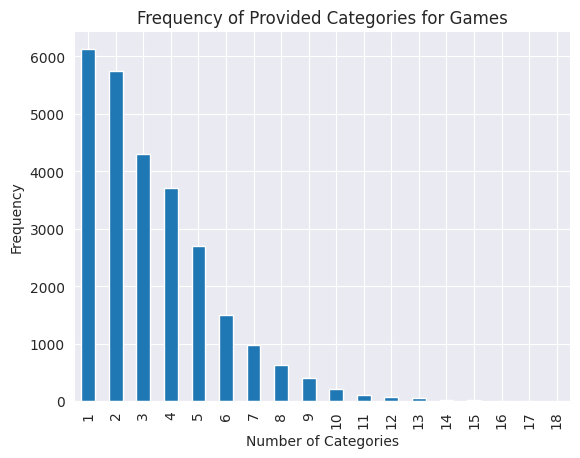

In [11]:
# number of categories for each game
plt.figure()
steam['categories'].apply(lambda x: len(x)).value_counts().plot(kind = 'bar')
plt.xlabel('Number of Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Provided Categories for Games')
plt.show()

In [12]:
# list all unique labels as well as all labels occured in the dataset
def get_labels(data):
  unique_labels = []
  all_labels = []

  for labels in data:
    cur_label = []
    for label in labels:
      cur_label.append(label)
      if label not in unique_labels:
        unique_labels.append(label)
    all_labels.append(cur_label)
  
  print('Number of unique labels:', len(unique_labels))
  print('Number of total labels applied:', len(all_labels))
  
  return unique_labels, all_labels


In [13]:
unique_cats, all_cats = get_labels(steam['categories'])
unique_cats

Number of unique labels: 29
Number of total labels applied: 26564


['multi-player',
 'online multi-player',
 'local multi-player',
 'valve anti-cheat enabled',
 'single-player',
 'steam cloud',
 'steam achievements',
 'steam trading cards',
 'captions available',
 'partial controller support',
 'includes source sdk',
 'cross-platform multiplayer',
 'stats',
 'commentary available',
 'includes level editor',
 'steam workshop',
 'in-app purchases',
 'co-op',
 'full controller support',
 'steam leaderboards',
 'steamvr collectibles',
 'online co-op',
 'shared/split screen',
 'local co-op',
 'mmo',
 'vr support',
 'mods',
 'mods (require hl2)',
 'steam turn notifications']

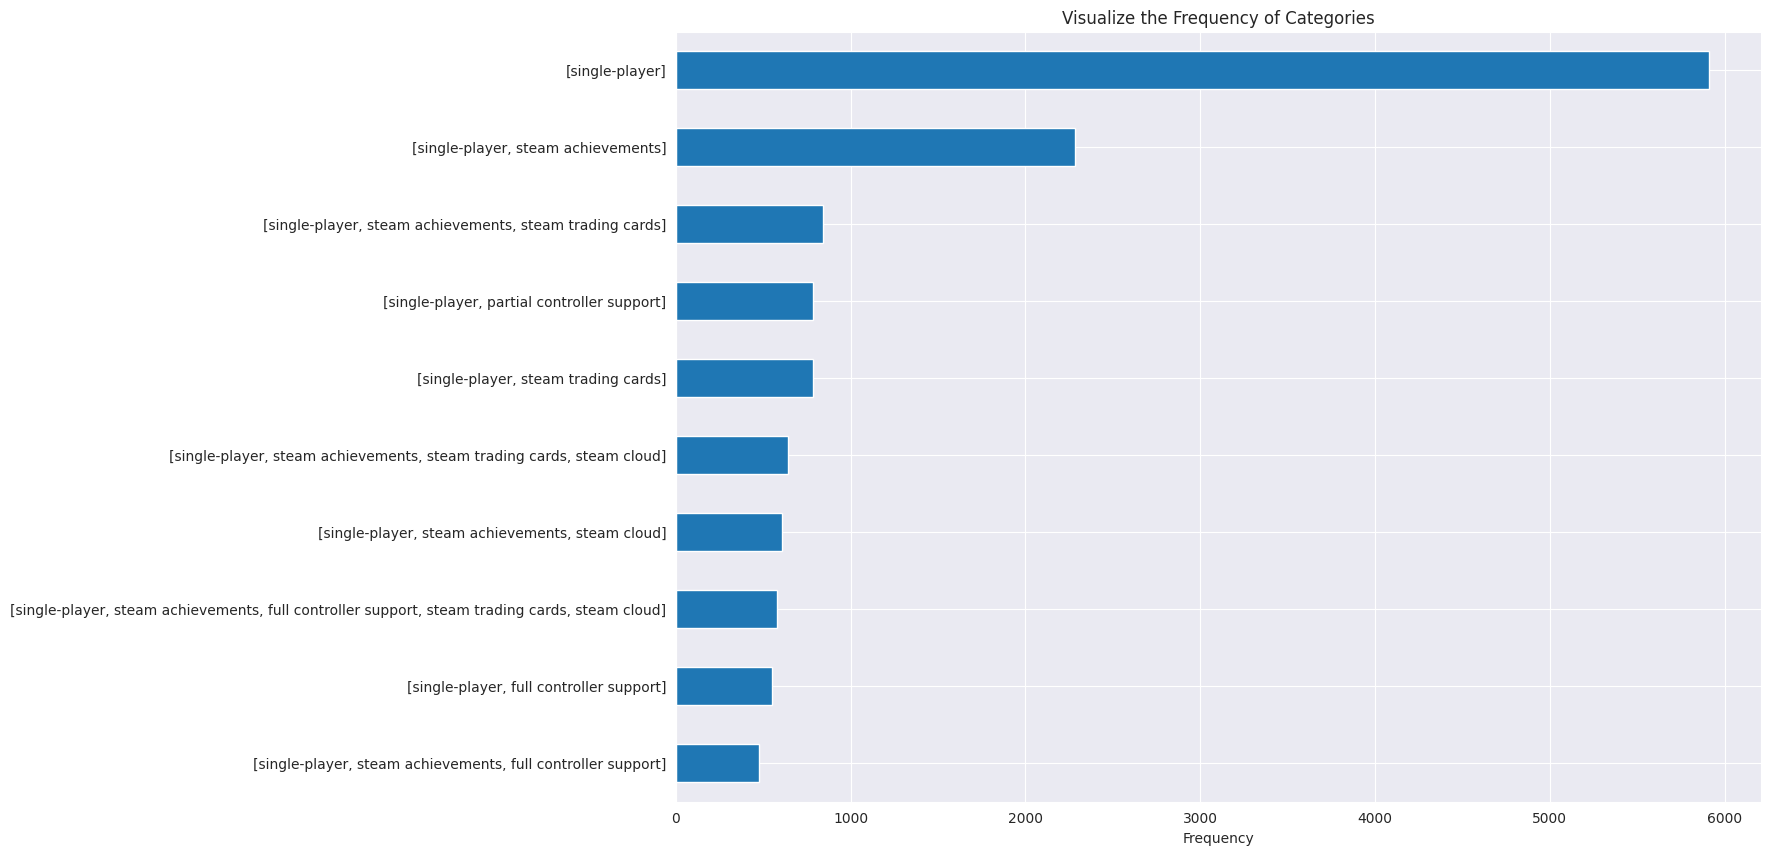

In [14]:
# visualize the top 10 categories
plt.figure(figsize = (14, 10))
pd.Series(all_cats).value_counts()[:10].plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.title('Visualize the Frequency of Categories')
plt.show()

In [15]:
# Clean the tag values into lists and lower cases
steam['steamspy_tags'] = steam['steamspy_tags'].apply(lambda x: x.split(";"))
steam['steamspy_tags'] = steam['steamspy_tags'].apply(lambda x: list(map(str.lower, x)))

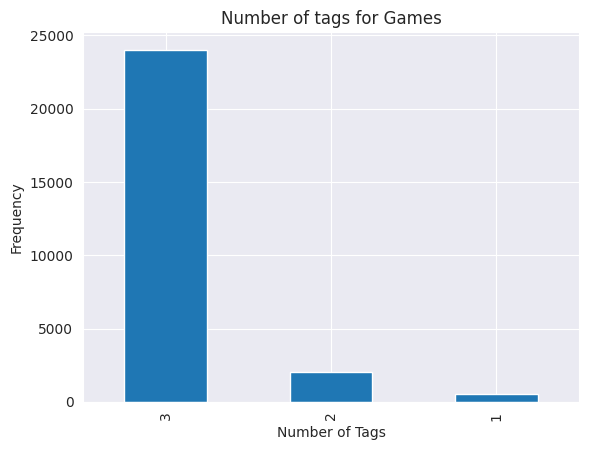

In [16]:
# number of categories for each game
plt.figure()
steam['steamspy_tags'].apply(lambda x: len(x)).value_counts().plot(kind = 'bar')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title('Number of tags for Games')
plt.show()

In [17]:
unique_tags, all_tags = get_labels(steam['steamspy_tags'])
unique_tags[:5]

Number of unique labels: 339
Number of total labels applied: 26564


['action', 'fps', 'multiplayer', 'world war ii', 'sci-fi']

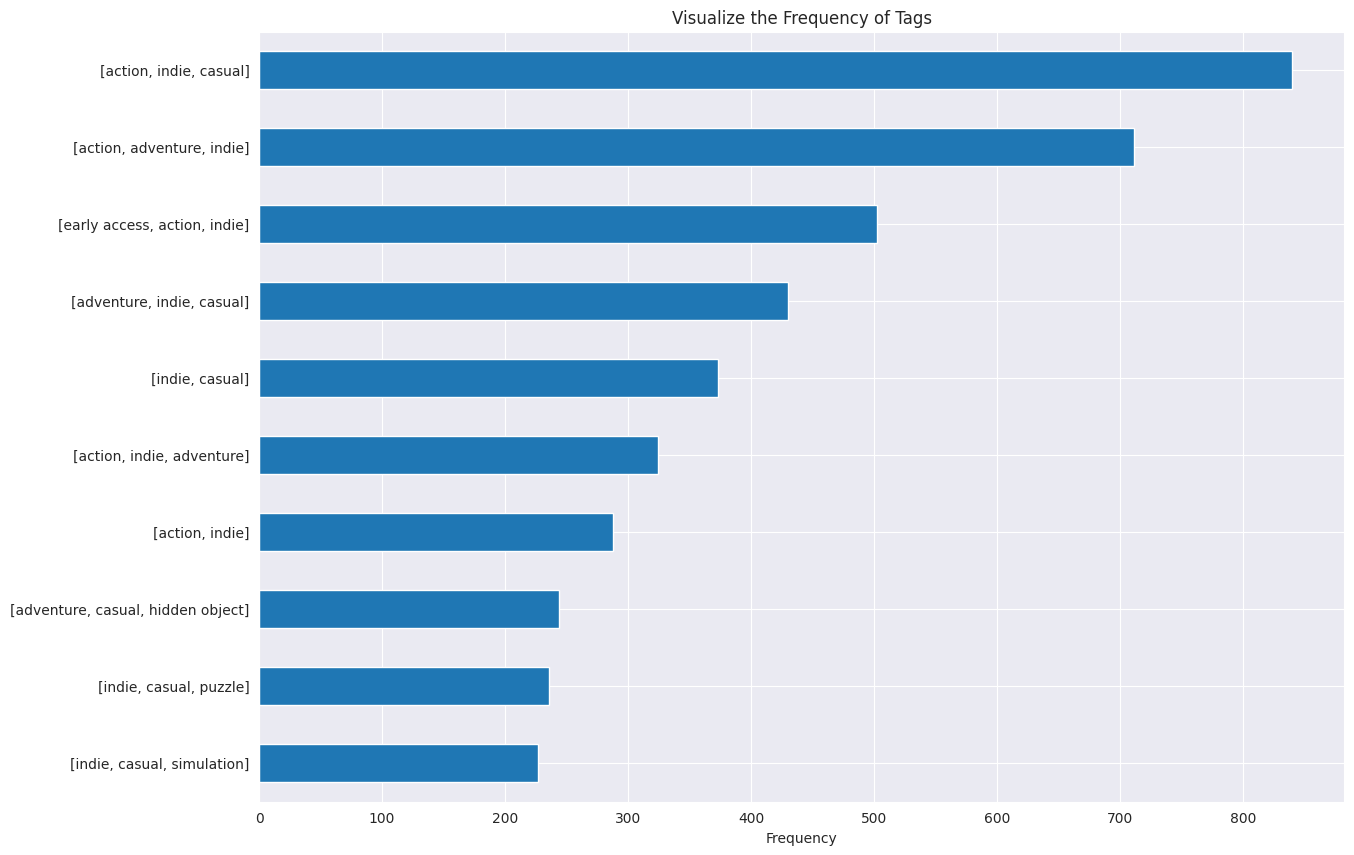

In [18]:
# visualize the top 10 tags
plt.figure(figsize = (14, 10))
pd.Series(all_tags).value_counts()[:10].plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.title('Visualize the Frequency of Tags')
plt.show()

In [19]:
# Clean the Genre values into lists and lower case
steam['genres'] = steam['genres'].apply(lambda x: x.split(";"))
steam['genres'] = steam['genres'].apply(lambda x: list(map(str.lower, x)))

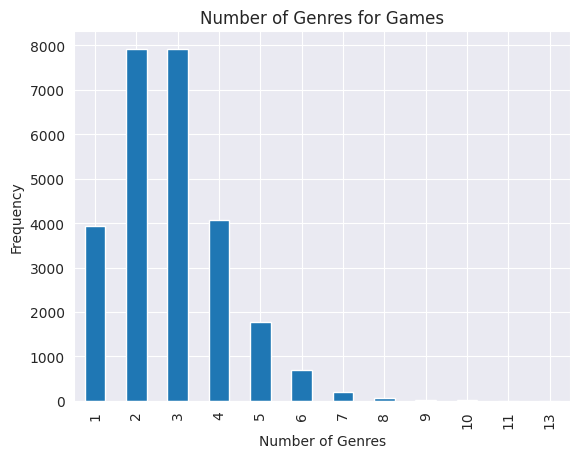

In [20]:
# number of categories for each game
plt.figure()
steam['genres'].apply(lambda x: len(x)).value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.title('Number of Genres for Games')
plt.show()

In [21]:
unique_genres, all_genres = get_labels(steam['genres'])
unique_genres[:5]

Number of unique labels: 29
Number of total labels applied: 26564


['action', 'free to play', 'strategy', 'adventure', 'indie']

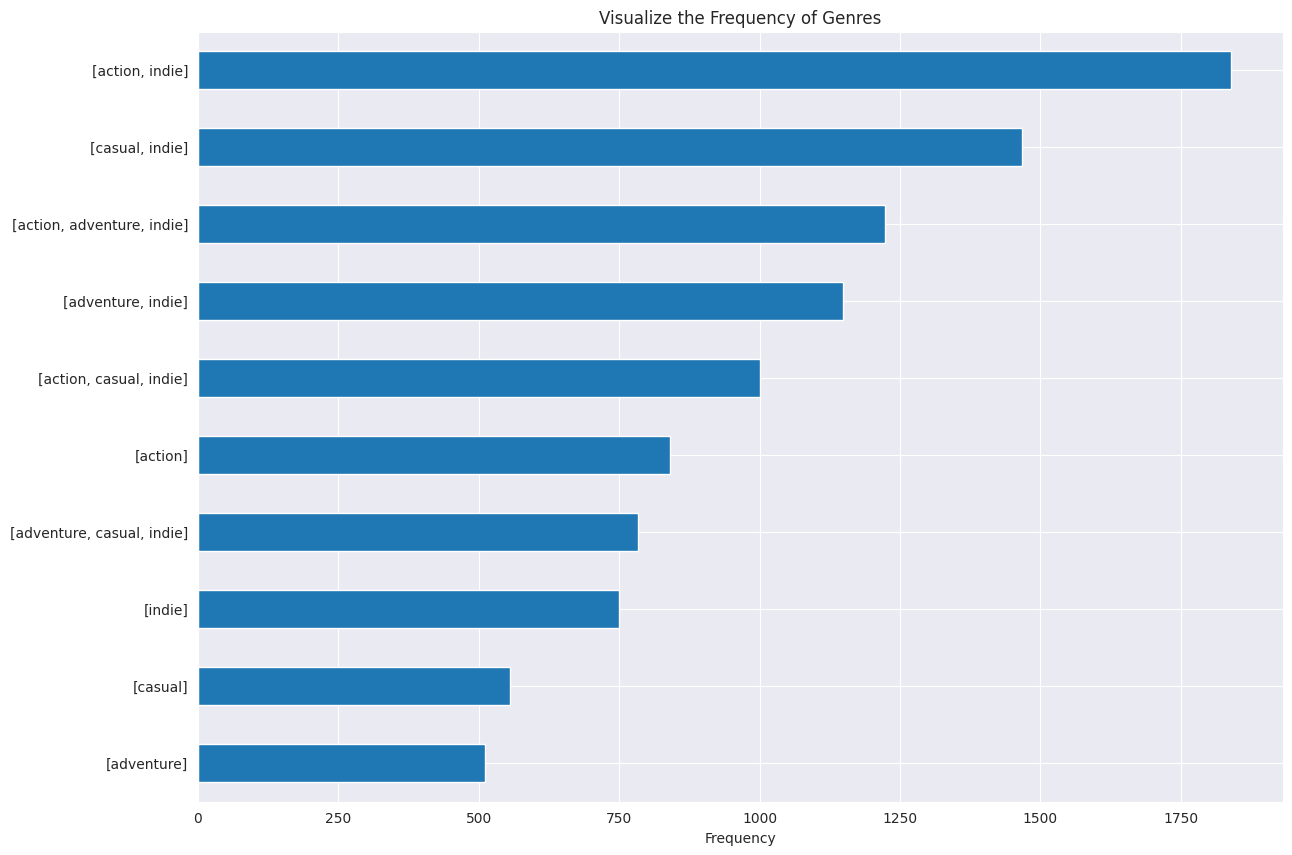

In [22]:
# visualize the top 10 genres
plt.figure(figsize = (14, 10))
pd.Series(all_genres).value_counts()[:10].plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.title('Visualize the Frequency of Genres')
plt.show()

# Select category, tag, and genre based on user input

In [23]:
user_category = 'single-player'
user_tag = 'indie'
user_genre = 'strategy'

user_index = steam.loc[(steam['categories'].map(lambda x: user_category in x)) &
          (steam['steamspy_tags'].map(lambda x: user_tag in x)) &
          (steam['genres'].map(lambda x: user_genre in x))].index
user_steam = steam.loc[user_index]

In [24]:
user_steam.head(2)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
30,1500,Darwinia,2005-07-14,1,Introversion Software,Introversion Software,windows;mac;linux,0,[single-player],"[indie, strategy]","[strategy, indie, rts]",0,472,158,182,273,500000-1000000,7.19
31,1510,Uplink,2006-08-23,1,Introversion Software,Introversion Software,windows;mac;linux,0,[single-player],"[indie, strategy]","[hacking, indie, strategy]",0,1602,152,65,77,500000-1000000,6.99


In [25]:
user_steam_desc = pd.merge(user_steam, steam_description, left_on = 'appid', right_on = 'steam_appid', how = 'left')

In [26]:
user_steam_desc.loc[user_steam_desc['detailed_description'].isna()].index
user_steam_desc.drop(user_steam_desc.loc[user_steam_desc['detailed_description'].isna()].index)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,steam_appid,detailed_description,about_the_game,short_description
0,1500,Darwinia,2005-07-14,1,Introversion Software,Introversion Software,windows;mac;linux,0,[single-player],"[indie, strategy]",...,472,158,182,273,500000-1000000,7.19,1500,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...
1,1510,Uplink,2006-08-23,1,Introversion Software,Introversion Software,windows;mac;linux,0,[single-player],"[indie, strategy]",...,1602,152,65,77,500000-1000000,6.99,1510,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...
2,1520,DEFCON,2006-09-29,1,Introversion Software,Introversion Software,windows;mac;linux,0,"[single-player, multi-player]","[indie, strategy]",...,2057,344,80,119,500000-1000000,7.19,1520,"Inspired by the 1983 cult classic film, Wargam...","Inspired by the 1983 cult classic film, Wargam...","Inspired by the 1983 cult classic film, Wargam..."
3,2720,ThreadSpace: Hyperbol,2007-07-12,1,Iocaine Studios,Atari,windows,0,"[single-player, multi-player, includes level e...","[action, indie, strategy]",...,31,9,0,0,20000-50000,3.99,2720,ThreadSpace: Hyperbol is an action-strategy ga...,ThreadSpace: Hyperbol is an action-strategy ga...,ThreadSpace: Hyperbol is an action-strategy ga...
4,15400,Harvest: Massive Encounter,2009-01-23,1,Oxeye Game Studio,Oxeye Game Studio,windows;mac;linux,0,"[single-player, steam achievements]","[strategy, indie]",...,89,21,0,0,20000-50000,5.79,15400,<p>Harvest: Massive Encounter is an award-winn...,<p>Harvest: Massive Encounter is an award-winn...,Harvest: Massive Encounter is an award-winning...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,1053780,Pixel Art Monster - Color by Number,2019-04-03,1,Pixel Art Monster - Color by Number,Pixel Art Monster - Color by Number,windows,0,[single-player],"[action, adventure, casual, indie, rpg, simula...",...,3,0,0,0,0-20000,2.89,1053780,Pixel Art Monster - Color by Number is an addi...,Pixel Art Monster - Color by Number is an addi...,Pixel Art Monster - Color by Number is an addi...
2425,1055090,Embark,2019-04-18,1,Overly Complicated Games,Overly Complicated Games,windows,0,"[single-player, steam achievements, steam clou...","[indie, simulation, strategy, early access]",...,73,15,0,0,0-20000,19.49,1055090,Embark is a colony management game with a focu...,Embark is a colony management game with a focu...,Inspired by the deep simulation of Dwarf Fortr...
2426,1055140,10-4 Indirect Contact,2019-04-15,1,睦月文化,睦月文化,windows,0,"[single-player, steam cloud]","[indie, strategy]",...,48,5,0,0,0-20000,2.89,1055140,When the extraterrestrial civilization ignites...,When the extraterrestrial civilization ignites...,10-4 Indirect Contact is a RTT game. Player wh...
2427,1055890,Game Of Puzzles: Nature,2019-04-11,1,Snkl Studio,Snkl Studio,windows,0,"[single-player, steam achievements, steam cloud]","[casual, indie, strategy]",...,4,2,0,0,0-20000,0.79,1055890,<strong>Game Of Puzzles: Nature</strong> - is ...,<strong>Game Of Puzzles: Nature</strong> - is ...,A puzzle game in which you have to assemble a ...


#Train the LDA Model

##Clean and tokenize the data

In [27]:
def initial_clean(text):
    """
    Clean up text input
    """
    text = re.sub('<[^<]+?>', '', text)
    text = text.replace('&quot', '').replace('\r\n', '')
    #text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Remove common stop words
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Put word into stem for geater overlap
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    Aggregate the preprocessing steps
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [28]:
# clean text and name and create new column "tokenized"
t1 = time.time()
user_steam_desc['tokenized'] = user_steam_desc['detailed_description'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(user_steam_desc), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 2429 articles: 0.17265806992848715 min


### Get word frequency

We'll use nltk to get a word frequency (by count) here and only keep the top most used words to train the LDA model on

In [29]:
all_words = [word for item in list(user_steam_desc['tokenized']) for word in item]
fdist = FreqDist(all_words)
# number of unique words
len(fdist) 

32479

In [30]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]
top_k_words[:10]

[('game', 6405),
 ('new', 2144),
 ('play', 2131),
 ('level', 2069),
 ('player', 1976),
 ('use', 1775),
 ('differ', 1715),
 ('enemi', 1642),
 ('build', 1543),
 ('world', 1542)]

In [31]:
# choose k and visually inspect the bottom 10 words of the top k
k = 5000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('shroud', 5),
 ('alphanumer', 5),
 ('unbound', 5),
 ('comet', 5),
 ('austin', 5),
 ('archeologist', 5),
 ('fullest', 5),
 ('vp', 5),
 ('gamefeatur', 5),
 ('leap', 5)]

In [32]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
frequent_words = set(['game', 'play', 'player', 'new'])
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words and word not in frequent_words]

In [33]:
user_steam_desc['tokenized'] = user_steam_desc['tokenized'].apply(keep_top_k_words)

In [34]:
# document length
user_steam_desc['doc_len'] = user_steam_desc['tokenized'].apply(lambda x: len(x))
doc_lengths = list(user_steam_desc['doc_len'])
user_steam_desc.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 2429 
average document length 113.37752161383285 
minimum document length 0 
maximum document length 1967


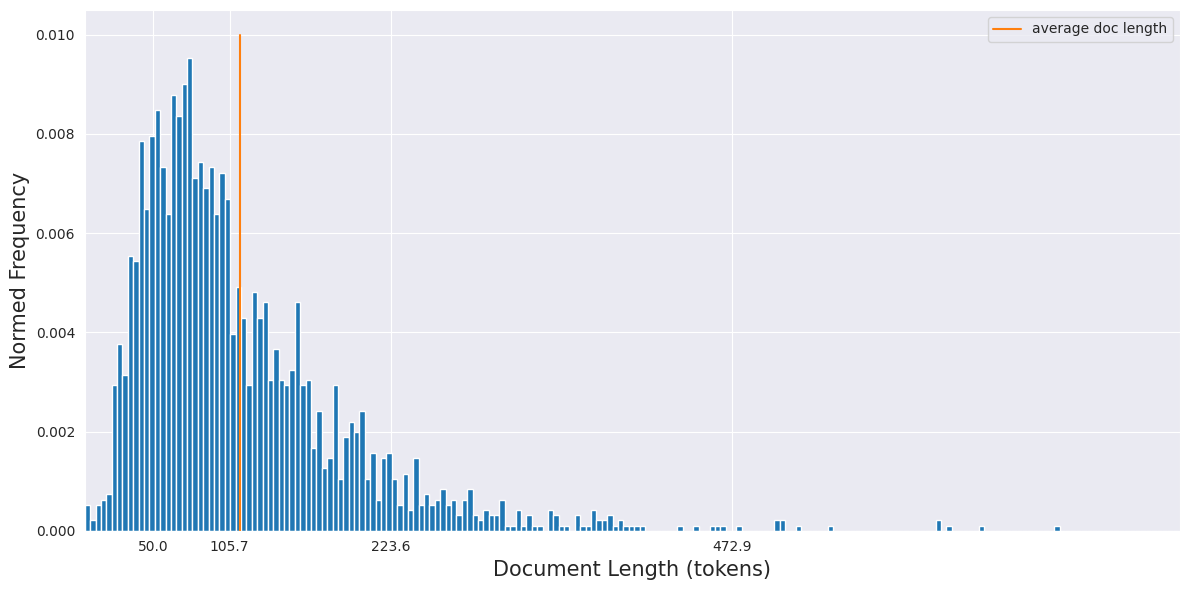

In [35]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(1000),num=5, base=10.0))
plt.xlim(0,800)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.01,100)], np.linspace(0.0,0.01,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Drop short articles
LDA does not work very well on short documents, so we will drop short descriptions.

In [36]:
user_steam_desc = user_steam_desc[user_steam_desc['tokenized'].map(len) >= 30]
user_steam_desc = user_steam_desc[user_steam_desc['tokenized'].map(type) == list]
user_steam_desc.reset_index(drop=True,inplace=True)
print(len(user_steam_desc), "descriptions")

2319 descriptions


In [37]:
user_steam_desc.head(1)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,negative_ratings,average_playtime,median_playtime,owners,price,steam_appid,detailed_description,about_the_game,short_description,tokenized
0,1510,Uplink,2006-08-23,1,Introversion Software,Introversion Software,windows;mac;linux,0,[single-player],"[indie, strategy]",...,152,65,77,500000-1000000,6.99,1510,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,"[agent, make, live, perform, job, major, corpo..."


### Split into training and testing set

In [38]:
msk = np.random.rand(len(user_steam_desc)) < 0.99

In [39]:
train_df = user_steam_desc[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = user_steam_desc[~msk]
test_df.reset_index(drop=True,inplace=True)

In [40]:
print(len(user_steam_desc),len(train_df),len(test_df))

2319 2288 31


## LDA Model

In [41]:
def train_lda(data):
    """
    Defines the LDA model
    """
    num_topics = 5
    chunksize = 150
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=1e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(user_steam_desc), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [42]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  2319 articles:  0.05467833280563354 min


In [43]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(0,
  '0.014*"world" + 0.013*"battl" + 0.009*"charact" + 0.008*"hero" + 0.008*"strategi" + 0.008*"power" + 0.007*"uniqu" + 0.007*"fight" + 0.007*"one" + 0.007*"skill" + 0.006*"take" + 0.006*"make" + 0.006*"tactic" + 0.006*"war" + 0.006*"monster" + 0.006*"team" + 0.006*"enemi" + 0.006*"stori" + 0.005*"combat" + 0.005*"differ"'),
 (1,
  '0.027*"enemi" + 0.014*"build" + 0.014*"tower" + 0.013*"differ" + 0.013*"use" + 0.011*"defens" + 0.011*"weapon" + 0.010*"resourc" + 0.010*"upgrad" + 0.010*"unit" + 0.009*"level" + 0.008*"battl" + 0.008*"type" + 0.008*"fight" + 0.008*"planet" + 0.008*"attack" + 0.008*"destroy" + 0.007*"strategi" + 0.007*"mode" + 0.007*"defend"'),
 (2,
  '0.019*"build" + 0.015*"town" + 0.014*"ship" + 0.013*"mine" + 0.012*"mani" + 0.010*"busi" + 0.010*"industri" + 0.010*"get" + 0.009*"manag" + 0.009*"complet" + 0.009*"space" + 0.008*"simul" + 0.008*"road" + 0.008*"develop" + 0.008*"citi" + 0.008*"larg" + 0.008*"differ" + 0.007*"resourc" + 0.007*"make" + 0.007*"fleet"'),
 (3

In [44]:
lda.show_topic(topicid=0, topn=20)

[('world', 0.014090748),
 ('battl', 0.012979635),
 ('charact', 0.0087250965),
 ('hero', 0.008292199),
 ('strategi', 0.0075556543),
 ('power', 0.0075056604),
 ('uniqu', 0.0072664614),
 ('fight', 0.0067519583),
 ('one', 0.006696462),
 ('skill', 0.0066831335),
 ('take', 0.0063767866),
 ('make', 0.0062983744),
 ('tactic', 0.005958662),
 ('war', 0.005806462),
 ('monster', 0.005747087),
 ('team', 0.0056127375),
 ('enemi', 0.0055589327),
 ('stori', 0.005539857),
 ('combat', 0.005438364),
 ('differ', 0.0050872015)]

In [45]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index]['tokenized'])
print(random_article_index)

1211


In [46]:
print(train_df.iloc[random_article_index]['detailed_description'])

Why be good when you can be... bad? Cursed Treasure 2 is an addictive tower-defense game that puts the power of darkness at your fingertips. As a creature of ultimate evil, you don't ask for much... just to raze the odd kingdom, and have your cache of all-powerful magical gems safely hidden away. Too bad the (ugh) good guys are out to steal them. Using the powers of the orcs, demons, and undead, you'll build unique and powerful towers along paths to destroy any hero that dares get close. <br><br><img src="https://steamcdn-a.akamaihd.net/steam/apps/643960/extras/ct2example.png?t=1511185920" ><br><br><br>Upgrade your undead cemeteries to instill fear in foes that makes them flee in the opposite direction, or turn your demonic temples into mighty icons capable of turning the ground to lava beneath anyone's feet. You'll upgrade and enhance each unique type, and of course, unlock spells of your own to enter the fray... when the going gets tough, the tough drop meteors on everyone else, afte

In [47]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

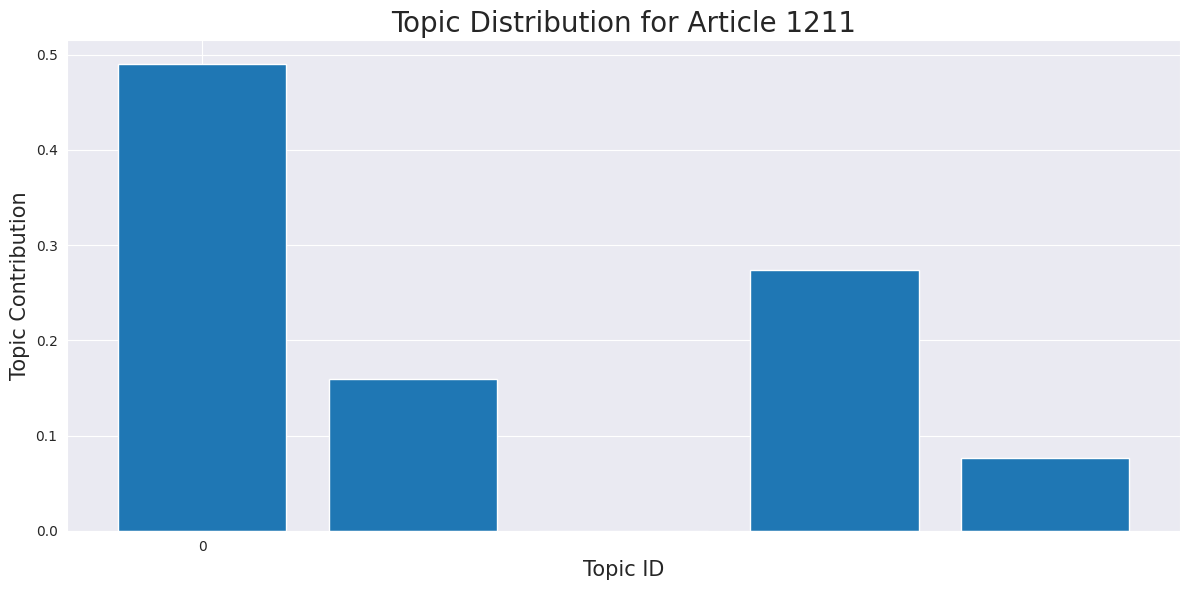

In [48]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(0,10,1))
fig.tight_layout()
plt.show()

In [49]:
# print the top 3 contributing topics and their words
for i in doc_distribution.argsort()[-3:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('world', 0.014090748), ('battl', 0.012979635), ('charact', 0.0087250965), ('hero', 0.008292199), ('strategi', 0.0075556543), ('power', 0.0075056604), ('uniqu', 0.0072664614), ('fight', 0.0067519583), ('one', 0.006696462), ('skill', 0.0066831335)] 

3 [('puzzl', 0.02393772), ('level', 0.018086815), ('card', 0.010721216), ('time', 0.009840261), ('use', 0.009367871), ('get', 0.008255333), ('differ', 0.008177721), ('find', 0.007845393), ('color', 0.00772349), ('one', 0.0075825476)] 

1 [('enemi', 0.02725102), ('build', 0.014358239), ('tower', 0.014246879), ('differ', 0.013118884), ('use', 0.012630599), ('defens', 0.011179467), ('weapon', 0.010872855), ('resourc', 0.010269415), ('upgrad', 0.01019308), ('unit', 0.009663382)] 



# Simlarity Queries and Unseen Data

In [50]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

17


In [51]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index]['tokenized'])

In [52]:
print(test_df.iloc[random_article_index]['detailed_description'])
print(test_df.iloc[random_article_index]['tokenized'])

A fearsome Chieftain is gathering an army, intent on the subjugation of the realm. The Villagers cry out for a hero! Someone to rise up and rescue them from their plight. This burden falls to you. Build a city, train an army, and equip your subjects. Seek out the assistance of helpful allies, such as dwarves, amazons, and sorceresses. With allies to help, and an army of your own, you can defeat the invading army and make the realm safe again!<img src="https://battlecruiser.ru/wstd/english.jpg" crossorigin="anonymous"><h2 class="bb_tag"><strong>Features</strong></h2><ul class="bb_ul">    <li>7 basic units, with a further 15 available as upgrades!<br>    </li><li>Intriguing story with beautifully drawn artwork.<br>    </li><li>3 Vastly different Classes for you to choose from: Warlord, Sorcerer, and Treasurer. Over 70 different skills in all!<br>    </li><li>Diverse array of spells: Firewall, Lightning, Meteor Shower, Titan's Fist, Summon Elemental, Poisonous Cloud, Transmutation, and mo

In [53]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

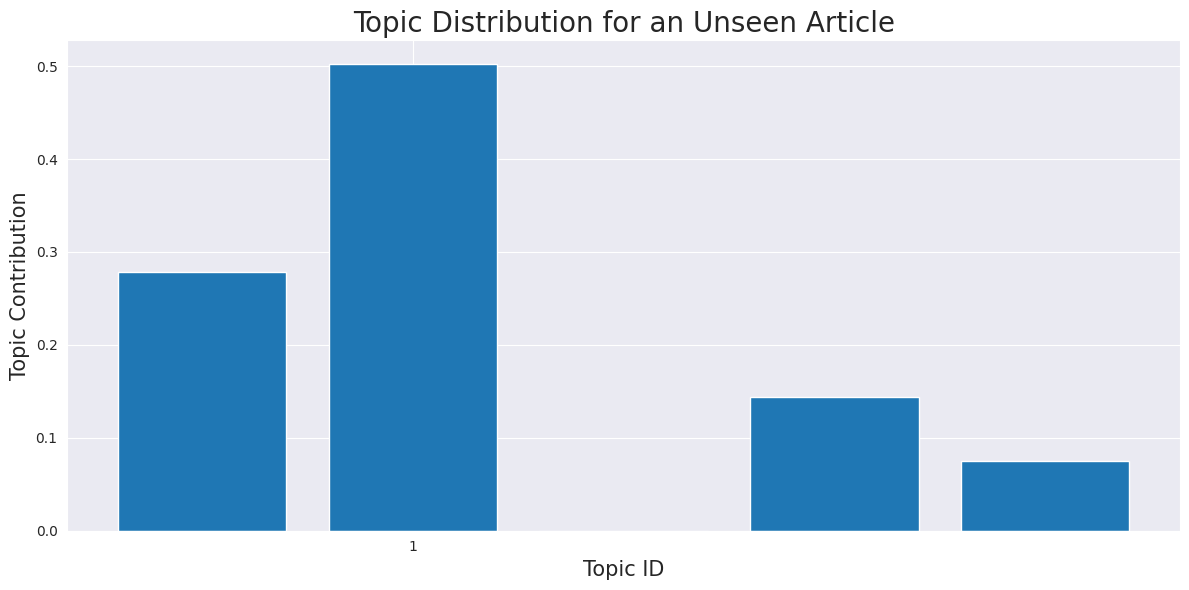

In [54]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(1,10,1))
fig.tight_layout()
plt.show()

In [55]:
# print the top 3 contributing topics and their words
for i in new_doc_distribution.argsort()[-3:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

1 [('enemi', 0.02725102), ('build', 0.014358239), ('tower', 0.014246879), ('differ', 0.013118884), ('use', 0.012630599), ('defens', 0.011179467), ('weapon', 0.010872855), ('resourc', 0.010269415), ('upgrad', 0.01019308), ('unit', 0.009663382)] 

0 [('world', 0.014090748), ('battl', 0.012979635), ('charact', 0.0087250965), ('hero', 0.008292199), ('strategi', 0.0075556543), ('power', 0.0075056604), ('uniqu', 0.0072664614), ('fight', 0.0067519583), ('one', 0.006696462), ('skill', 0.0066831335)] 

3 [('puzzl', 0.02393772), ('level', 0.018086815), ('card', 0.010721216), ('time', 0.009840261), ('use', 0.009367871), ('get', 0.008255333), ('differ', 0.008177721), ('find', 0.007845393), ('color', 0.00772349), ('one', 0.0075825476)] 



In [56]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(2288, 5)

In [57]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [58]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [59]:
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [60]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
list(most_similar_df['name'])
list(most_similar_df['short_description'])

['Towers of Altrac is a 3D Tower Defense cooperation game for up to 4 players with an innovative A.I. system “S.A.D.”, which makes your enemies intelligent . Fight against the horde of Goblins, Orcs, Dragons and other monsters on 62 unique maps. The game is for every level of player experience.',
 'Evolution II: Fighting for Survival is a real-time action life simulation game. Conquer a world of randomly generated, evolving species.',
 'Once upon a time all was peaceful and serene in the far off land of Camalon, but the silence has been broken as the Orc hordes have returned to the peaceful kingdom to claim the land that they once held most sacred.',
 'Pixel strategy that combines real-time and turn-based gameplay. 17 factions from vampire queens to mechanical golems.',
 'Prepare to embark on an epic adventure with tiny heroes in this tower defence game with a twist! Summon unique guardians to defend Lunalie against various enemies as she journeys through the wilderness of Prism.',
 "A

In [61]:
app_ids = list(most_similar_df['appid'])
print(app_ids)

[333660, 347580, 371360, 390920, 431230, 568910, 681350, 921450, 929330, 1055140]


# Game Statistics Analysis

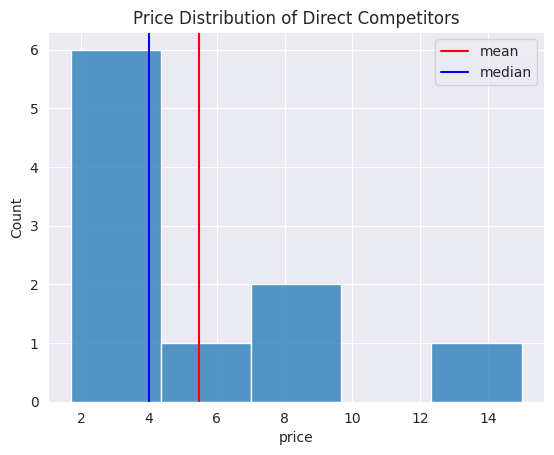

In [62]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.histplot(data=most_similar_df['price'])
ax.axvline(x=np.mean(most_similar_df['price']), color='r', label='mean')
#plt.text(np.mean(most_similar_df['price'])+0.1,5.5,'mean',rotation=0)
ax.axvline(x=np.median(most_similar_df['price']), color='b', label='median')
#plt.text(np.median(most_similar_df['price'])+0.1,5.5,'median',rotation=0)
plt.title("Price Distribution of Direct Competitors")
plt.legend()

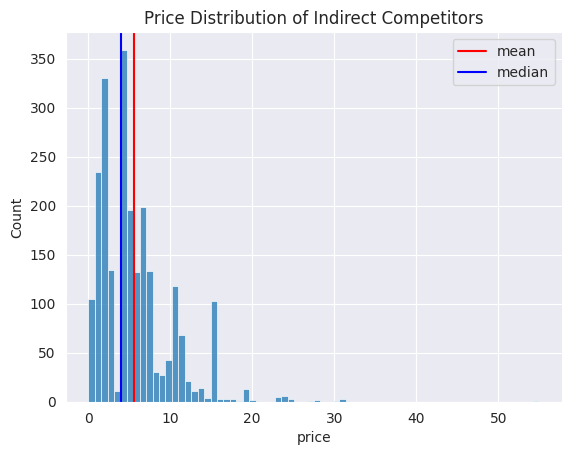

In [63]:
ax = sns.histplot(data=user_steam_desc['price'])
ax.axvline(x=np.mean(user_steam_desc['price']), color='r', label='mean')
#plt.text(np.mean(user_steam_desc['price'])+1,350,'mean',rotation=0)
ax.axvline(x=np.median(user_steam_desc['price']), color='b', label='median')
#plt.text(np.median(user_steam_desc['price'])-6.5,350,'median',rotation=0)
plt.title("Price Distribution of Indirect Competitors")
plt.legend()

Text(0.5, 1.0, 'Owner Distribution of Indirect Competitors')

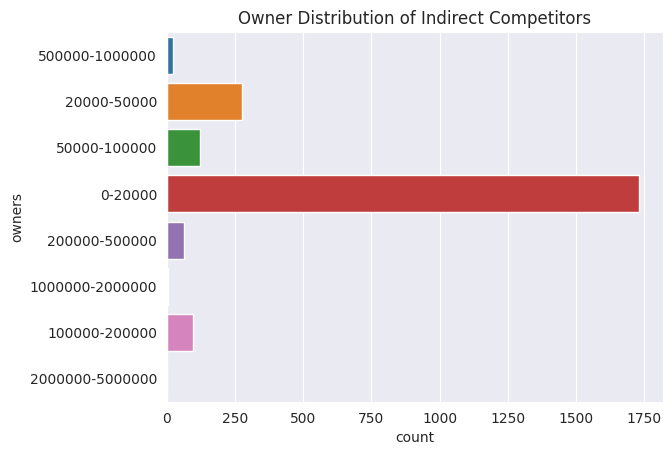

In [64]:
sns.countplot(y=user_steam_desc['owners'])
plt.title("Owner Distribution of Indirect Competitors")

Text(0.5, 1.0, 'Owner Distribution of Direct Competitors')

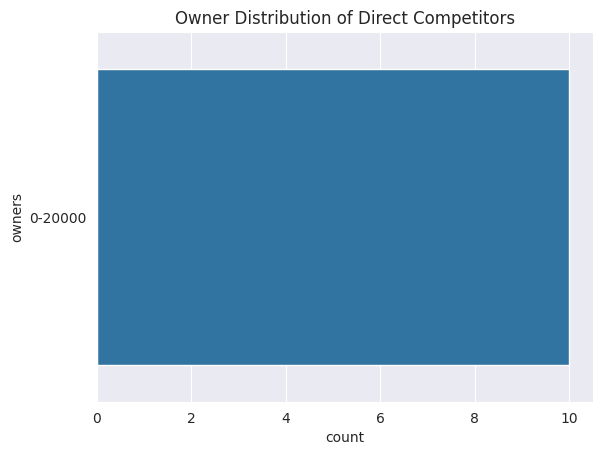

In [65]:
sns.countplot(y=most_similar_df['owners'])
plt.title("Owner Distribution of Direct Competitors")

# User Review Analysis

In [ ]:
review_path = os.path.join(colab_root, "reviews.csv")
download_if_missing("https://storage.googleapis.com/eecs6895-project2/reviews.csv",
                     review_path)

df_reviews = pd.read_csv('reviews.csv')

In [ ]:
# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())

(6417106, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


### Data Preprocessing

In [ ]:
# convert review text to string
df_reviews["review_text"] = df_reviews["review_text"].astype(str)
df_reviews["review_votes"] = df_reviews["review_votes"].astype(str)
df_reviews.review_text = df_reviews.review_text.apply(lambda s: s.strip())

# drop the reviews with null score
df_reviews = df_reviews[df_reviews["review_score"].notnull()]

# change the scores from 1, -1 to 1 and 0
df_reviews["review_score"] = \
np.where(df_reviews["review_score"]==-1, 0, df_reviews["review_score"])

In [ ]:
# Remove early access comments
# These are the reviews with no comments writen by a human/reviewer. 
df_reviews = df_reviews[df_reviews.review_text != "Early Access Review"]
df_reviews = df_reviews[~df_reviews.review_text.isin(['nan'])]
print(df_reviews.shape)

# Drop duplicates if there is any
df_reviews.drop_duplicates(['review_text', 'review_score'], inplace = True)
print(df_reviews.shape)

(5385114, 5)
(4468409, 5)


In [ ]:
# Text cleaning: replace heart, which originally represents F words, with '**' to improve embedding accuracy since it will impact the classifier in negative reviews
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

df_reviews['review_text_clean'] = df_reviews.review_text.apply(replace_hearts_with_PAD)

In [ ]:
len(df_reviews[(df_reviews["app_id"]==10) & (df_reviews["review_score"]==1)])

9930

In [ ]:
# Select negative reviews
neg_reviews = df_reviews[(df_reviews.app_id.isin(app_ids)) & (df_reviews.review_score == 0)]
print(len(neg_reviews))
#neg_reviews = neg_reviews.sample(n=2000, random_state = 1234)
all_intents = neg_reviews.review_text_clean.tolist()

print(neg_reviews.shape)
display(neg_reviews.head())

133
(133, 6)


,app_id,app_name,review_text,review_score,review_votes,review_text_clean
3354367,275350,Sentinel 3: Homeworld,This was a solid tower defense game on android...,0,0,This was a solid tower defense game on android...
3354369,275350,Sentinel 3: Homeworld,"I hate myself for trying to play this game, it...",0,1,"I hate myself for trying to play this game, it..."
3354373,275350,Sentinel 3: Homeworld,Pro: Four difficulty levels. Double speed o...,0,1,Pro: Four difficulty levels. Double speed o...
3354376,275350,Sentinel 3: Homeworld,This game has all the trappings of the tried a...,0,0,This game has all the trappings of the tried a...
3354384,275350,Sentinel 3: Homeworld,Tower Defense games are fun to me. I own a bun...,0,1,Tower Defense games are fun to me. I own a bun...


In [ ]:
# Split reviews into sentences
# Remove sentences with less than 4 words
all_sents = []
for intent in all_intents:
    for sent in nltk.sent_tokenize(intent):
        if len(sent.split()) > 4:
            all_sents.append(sent)
print(len(all_sents))            
all_intents = all_sents

966


### Sentence Embedding

In [ ]:
!pip install -U -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.8/661.8 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# for Sentence Transformer models
from sentence_transformers import SentenceTransformer
import tensorflow as tf

In [ ]:
# To limit allocating the whole GPU memory by Pytorch run this cell. 


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

model_st1 = SentenceTransformer('all-mpnet-base-v2')
# model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
# model_st3 = SentenceTransformer('all-distilroberta-v1')

embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
# embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
# embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

## Dimensionality Reductions and Clustering

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
! conda install -c conda-forge hdbscan -y -q

Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import umap.umap_ as umap # dimensionality reduction
import hdbscan # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters, 
# we use hyperopt package:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

In [ ]:
# Reference: https://www.kaggle.com/code/dardodel/steam-reviews-auto-topic-modeling-w-transformers
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

### Use Bayesian Optimization with Hyperopt

In [ ]:
# Reference: https://www.kaggle.com/code/dardodel/steam-reviews-auto-topic-modeling-w-transformers
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05) # 0.05
    
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.5 #0.5 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [ ]:
# Define hyperparameter search space
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25

In [ ]:
%%time
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

 96%|█████████▌| 24/25 [03:29<00:06,  6.82s/trial, best loss: 0.15320910973084886]

In [ ]:
C_ = 11
for index, clust in enumerate(best_clusters_use.labels_):
  if clust == C_:
    print(all_intents[index])
    print()

## Automatic Cluster Labeling

For the automatic cluster labeling, we use spacy library to get the words POS (part of speech). From each cluster, we concatenate the most common verb, direct object, and top two nouns to build the cluster topic/label.

In [ ]:
import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
data_clustered = pd.DataFrame(data = list(zip(all_intents,best_clusters_use.labels_)),
                             columns = ['text', 'label_st1'])
data_clustered.head()

In [ ]:
example_category = data_clustered[data_clustered['label_st1']==2].reset_index(drop=True)
example_category.head() 

## Find the IDF of every word

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

sent_with_word_lemma = []
for intent in all_intents:
    doc = nlp(intent)
    sent_temp = ""
    this_one = False
    for token in doc:
        if (token.pos_ in ['VERB', 'NOUN', 'ADJ']) or (token.dep_=='dobj'):
            sent_temp += token.lemma_.lower() + " "
    sent_with_word_lemma.append(sent_temp)

In [ ]:
def compute_IDF(documents):
    word_count = Counter()
    for doc in documents:
        if 'drops(players' in doc:
            print(doc)
            print(doc.split())
        words_set = set(doc.split())
        word_count.update(words_set)
    total = sum(word_count.values())
    return {k: round((np.log2(total / v)))  for k, v in word_count.items()} # log2 is the best choice for our work (feel free)
                                                                            # to try different functions.

word_IDF = compute_IDF(sent_with_word_lemma)

In [ ]:
def get_group(df, category_col, category):
    """
    Returns documents of a single category
    
    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """
    
    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category 

def most_common(lst, n_words):
    """
    Get most common words in a list of words
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    
    for k in list(counter): 
        if counter[k] ==1: 
            pass 
        else:
            counter[k] *= word_IDF[k] 

    return counter.most_common(n_words)

def extract_labels(category_docs, print_word_counts=False):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

   
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if (token.is_stop==False) and (len(str(token).strip()) > 0): 
                if token.pos_ == 'VERB':
                    verbs.extend([token.lemma_.lower()]) 

                elif token.dep_=='dobj':
                    dobjs.extend([token.lemma_.lower()]) 

                elif token.pos_=='NOUN':
                    nouns.extend([token.lemma_.lower()]) 
                    
                elif token.pos_=='ADJ':
                    adjs.extend([token.lemma_.lower()])

    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter=collections.Counter(word_lst)
            print(counter)
    
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label

def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)['text'])
        label_dict[label] = extract_labels(current_category)
        
    summary_df = (df.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text':'count'})
                    .sort_values('count', ascending=False))
    
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)
    
    return summary_df

In [ ]:
cluster_summary = apply_and_summarize_labels(data_clustered, 'label_st1')

In [ ]:
pd.set_option('display.max_rows', None)
cluster_summary

,label_st1,count,label
0,-1,148,play_game_time
47,46,32,play_achievement_level_boss
56,55,26,look_game_90
59,58,25,fix_expansion_game_developer
9,8,22,boil_enemy_mission_day
24,23,21,hold_part_mech_weapon
39,38,20,hit_rank_ship_weapon
41,40,19,remove_thumb_review_comment
52,51,18,choose_skill_trader_pirate
43,42,18,read_screen_toolbar_button


In [ ]:
C_ = 46
selected_reviews_1 = []
for index, clust in enumerate(best_clusters_use.labels_):
  if clust == C_:
    print(all_intents[index])
    print()
    selected_reviews_1.append(all_intents[index])


The playtime required to get a 100% achievements was too much, plus there was no count-down after the 100K aliens killed mark.

The levels are all very bland and 'samey,' there are very few enemy types (although they can vary in strength amongst their kind), and it is very easy.

There are only a small number of maps available, so the game repeats several of them with 'different' waves of enemies (which dont feel different at all due to the limited variety) and tries to extend gameplay by making you face absurdly high wave counts (50+ for most levels).

- The main issue, is that the various levels are a little too generic, this feeling is increased by the fact that waves are only made of one type of enemy at once, the game merely increasing the number and strength of those enemies.

Overall many levels feel too long and repetitive.

I like the idea of earning medals and awards that show up on the character's lapel.

Not that easy to take on and to play.

The leveling is INCREDIBLY slow

In [ ]:
C_ = 35
selected_reviews_2 = []
for index, clust in enumerate(best_clusters_use.labels_):
  if clust == C_:
       print(all_intents[index])
       print()
       selected_reviews_2.append(all_intents[index])

The skill tree is incredibly frustrating as it forces you to buy a number of useless skills before you can get to the good ones.

The useless skills will then fill up your queue during combat with abilities that you will likely never use and make your life harder.

Unless you enjoy combat that requires no skill and 100% luck.

Both of these have to be in your skill lineup at the same time, and they both have to be successful.

It used to be a chance game when you would just want to be able to hit your abilities... NOW you have to hope abilities appear on your skill tab even tho you chose the skill in your talent tree you need to be lucky if you can even see said skill.

Your skill wont help you in this game, if you don't have any luck.

There will be times where you want to shoot your enemy one last time, but the only things on the board are a bunch of repair nodes or extra scrap which are generally worse than useless.



In [ ]:
from collections import Counter
from wordcloud import WordCloud 

# define the word cloud function
def WordCloud_generator(data, title=None):
    
    # Keep top 1000 most frequent words
    most_freq = Counter(data).most_common(1000) 
    text = ' '.join([x[0] for x in most_freq])
    
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10,
                          collocations=False
                         ).generate(text)

    # plot the Word Cloud                      
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=25)
    plt.show() 

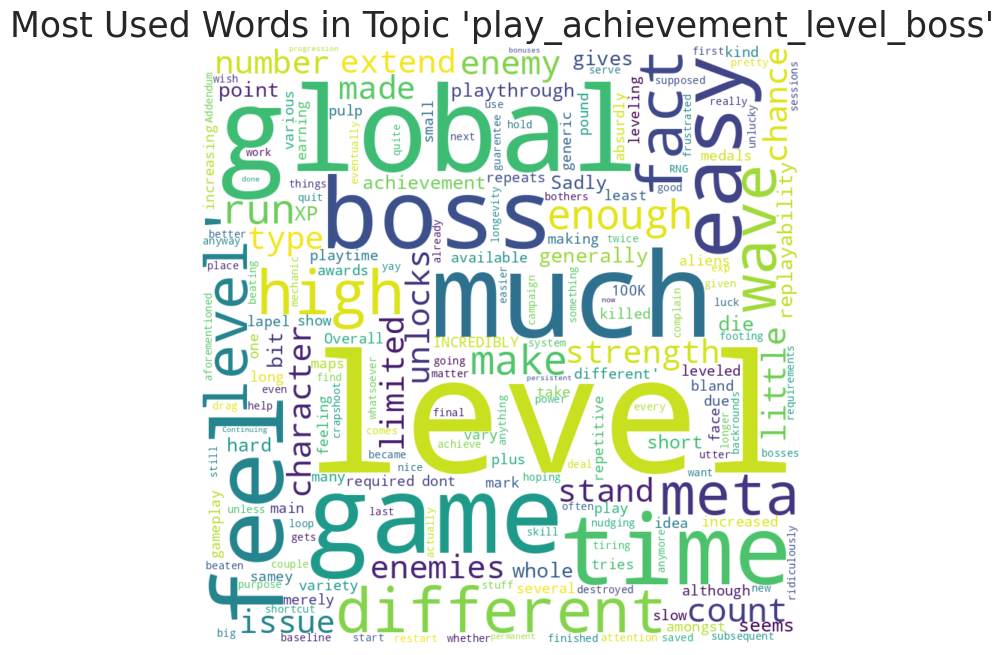

In [ ]:
stopwords = ['game', 'play', 'games', 'played']
for i in range(len(selected_reviews_1)):
  #print(selected_reviews_1[i])
  sentence = selected_reviews_1[i].split()
  sentence = [word for word in sentence if (word not in stopwords and word not in stop_words)]
  selected_reviews_1[i] = ' '.join(sentence)

WordCloud_generator(selected_reviews_1, "Most Used Words in Topic 'play_achievement_level_boss'")

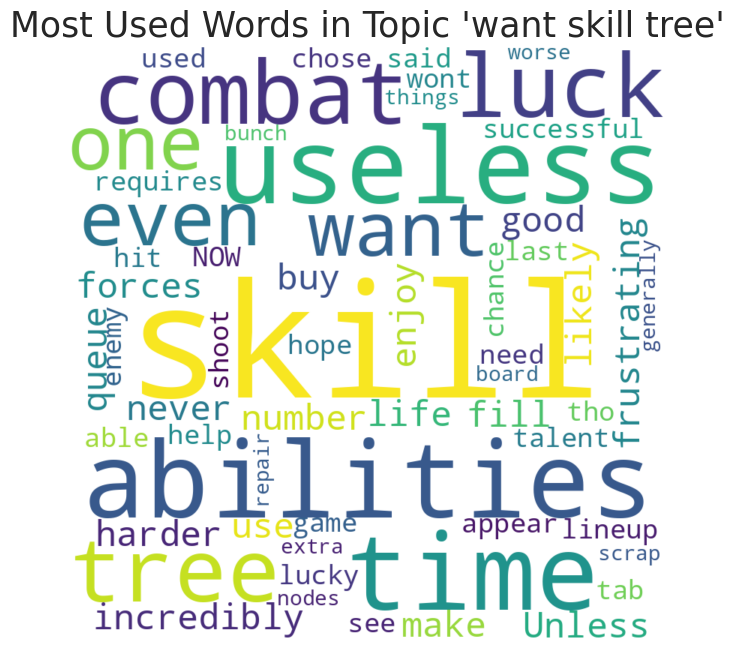

In [ ]:
stopwords = ['game', 'play', 'games', 'played']
for i in range(len(selected_reviews_2)):
  #print(selected_reviews_1[i])
  sentence = selected_reviews_2[i].split()
  sentence = [word for word in sentence if (word not in stopwords and word not in stop_words)]
  selected_reviews_2[i] = ' '.join(sentence)

WordCloud_generator(selected_reviews_2, "Most Used Words in Topic 'want skill tree'")